<a href="https://colab.research.google.com/github/ArunamAlok/DSSI/blob/main/Project1_Alok_Arunam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading basic libraries

import pandas as pd
import numpy as np

In [ ]:
# Loading the dataset

p_ds = pd.read_excel('/content/drive/My Drive/Colab Notebooks/ewaste.xlsx')

#Sub-setting the dataset as per the technical categories

p_ds1=p_ds.dropna(subset=['Technical Categorization:01 E-Waste Products'],axis=0)
p_ds1.reset_index(drop=True, inplace=True)

p_ds2=p_ds.dropna(subset=['Technical Categorization:02 Processes'],axis=0)
p_ds2.reset_index(drop=True, inplace=True)

p_ds3=p_ds.dropna(subset=['Technical Categorization:03 Recovered Materials'],axis=0)
p_ds3.reset_index(drop=True, inplace=True)

In [ ]:
#Loading the natual language processing toolkit and topic modelling framework

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from operator import length_hint
import re
import string

import gensim
from gensim import corpora, models, similarities


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Pre-processing the data

num_patents=p_ds["DWPI Title"].size

clean_titles=np.empty(num_patents, dtype=object)


tokenized_word=[]

#Tokenising
#Removing stop words and punctuations
#Stemming the words

for i in range(0,num_patents):
  tokenized_word=word_tokenize(p_ds["DWPI Title"][i])
  tokenized_word = [w for w in tokenized_word if w not in string.punctuation]
  titles=[]
  meaningful_words = [w for w in tokenized_word if not w in stop_words]
  for w in meaningful_words:
    titles.append(w)
  stemmed_words=[]
  for w in titles:
    stemmed_words.append(ps.stem(w))
  clean_titles[i]=stemmed_words


In [ ]:
#Sample

n=8500

print("Title:",p_ds["DWPI Title"][n])
print("")
print("Clean_Titles:",clean_titles[n])

from collections import Counter
count=Counter(clean_titles[n])
print(count.most_common(10))


Title: Manufacture of regenerated polycarbonate raw material for flame-retardant resin composition, involves determining raw material of polycarbonate resin in substrate of waste disk, and removing impurities from raw material

Clean_Titles: ['manufactur', 'regener', 'polycarbon', 'raw', 'materi', 'flame-retard', 'resin', 'composit', 'involv', 'determin', 'raw', 'materi', 'polycarbon', 'resin', 'substrat', 'wast', 'disk', 'remov', 'impur', 'raw', 'materi']
[('raw', 3), ('materi', 3), ('polycarbon', 2), ('resin', 2), ('manufactur', 1), ('regener', 1), ('flame-retard', 1), ('composit', 1), ('involv', 1), ('determin', 1)]


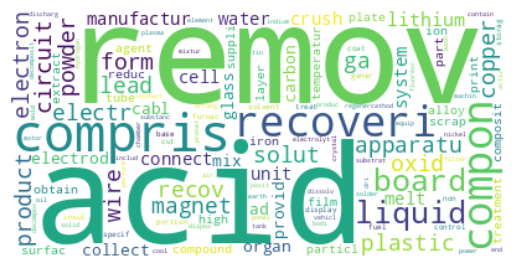

In [ ]:
#Word Cloud

import matplotlib.pyplot as plt

%matplotlib inline

words=[]
for i in range(0,len(clean_titles)):
  for w in clean_titles[i]:
    words.append(w)
#words_to_remove=()
words_to_remove=("materi","involv","wast",'batteri','use','method','separ', 'process','recycl','metal','contain','devic','resin','heat','e.g')

from wordcloud import WordCloud

text = " ".join([w for w in words if w not in words_to_remove])

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")

plt.show()

In [ ]:
#Term dictionary and documents-term matrix

bigram = models.Phrases(clean_titles)

final_titles = []
for i in range(0,num_patents):
  sent = clean_abstracts[i]
  temp_bigram = bigram[sent]
  final_titles.append(temp_bigram)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(final_titles)

# convert tokenized documents into a document-term matrix (bag-of-words)
corpus = [dictionary.doc2bow(text) for text in final_titles]

#TF IDF
tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

#Cosine Similarity
index_tfidf = similarities.MatrixSimilarity(tfidf[corpus])

In [ ]:
#Model Building

#LSI

from gensim.models import LsiModel
from IPython.display import display

num_topic_areas=10

lsi = LsiModel(tfidf[corpus], id2word=dictionary, num_topics=num_topic_areas)
corpus_lsi = lsi[corpus_tfidf]

lsi.print_topics(10)

classifications = [np.argmax(np.asarray(corpus_lsi[i])[:,1]) for i in range(0,num_patents)]

topics = pd.DataFrame({'topic': classifications, 'title': final_titles})

topics['topic'].value_counts()


for i in range(0,num_topic_areas):
    print("Topic", i + 1)
    display(topics.query('topic == @i').head(5))


Topic 1


,topic,title
1,0,"[recoveri, system, use, galvan, element, allow..."
4,0,"[method, appt, environment-friendli, dispos, h..."
5,0,"[clean, cathod_ray, tube, electroluminesc, tub..."
6,0,"[reprocess, household, industri, wast, pretrea..."
7,0,"[multi-stag, recycl, plant, televis, pictur_tu..."


Topic 2


,topic,title
13,1,"[preciou_metal, recoveri, scrap, oxid, ore, le..."
53,1,"[recoveri_nobl, metal, raw_materi, acid, leach..."
57,1,"[addit, lead_acid, batteri, mix, sulphat, soln..."
71,1,"[recov, cobalt, use, alloy, materi, lithium-io..."
149,1,"[leach, white, metal, involv, leach, white, me..."


Topic 3


,topic,title
3,2,"[use, batteri, cell, process, devic, circular,..."
37,2,"[fluid, densiti, meter, load, cell, includ, he..."
43,2,"[recharg, solar, batteri, cellular, telephon, ..."
59,2,"[control, charg, circuit, storag_batteri, prov..."
74,2,"[multistag, process, spent, small, batteri, co..."


Topic 4


,topic,title
27,3,"[fine, equiax, iron, alloy, particl, recov, co..."
30,3,"[remov, copper, film, print_circuit, board, us..."
93,3,"[a_method, recycl, gold, copper, scrap, gild, ..."
125,3,"[manufactur, high, conduct, electron, copper, ..."
215,3,"[recoveri, copper, wast, circuit_board, dip, c..."


Topic 5


,topic,title
44,4,"[blind, cannula, compris, distal, part, proxim..."
104,4,"[laser, separ, method, cathod_ray, tube, crt, ..."
1168,4,"[high, voltage-resist, direct_current, oxid, c..."
1239,4,"[conduct, connect, sheet, copper/nickel, metal..."
1283,4,"[cabl, peeler, posit, element, cover, cabl, cl..."


Topic 6


,topic,title
0,5,"[isol, earth, cabl, section, use, one, cabl, c..."
10,5,"[devic, cut, wire, piec]"
11,5,"[comminut, devic, electr, cabl, remov, fragmen..."
19,5,"[wire, strip, apparatu, strip, metal, wire, in..."
25,5,"[strip, cabl, recov, conductor, mill, groov, m..."


Topic 7


,topic,title
81,6,"[the, multi-sidelin, solid, fluidiz, pneumat, ..."
86,6,"[method, speical, clamp, use, extract, preciou..."
119,6,"[gold, leach, method, print_circuit, board, in..."
126,6,"[method, separ, recycl, solder, compon, circui..."
139,6,"[print_circuit, board, cast-off, process, reso..."


Topic 8


,topic,title
14,7,"[recoveri, lead, valu, secondari, lead, sourc,..."
20,7,"[treat, lead, dust, contg, lead, chlorid, hydr..."
31,7,"[niobium, metal, refractori, alloy, prodn, alu..."
42,7,"[fabric, metal, lead, e.g., partli, desulfur, ..."
150,7,"[reclaim, sulfur, iron_ore, slag, involv, carr..."


Topic 9


,topic,title
911,8,"[reactiv, agent, decompos, fluorin, compound, ..."
1125,8,"[electromagnet, interfer, shield, structur, el..."
1603,8,"[electr, contact, current, conductor, metal, s..."
2291,8,"[reactiv, reduc, mol.wt, polyarylen, polyeth, ..."
2529,8,"[electr, distribut, board, later, connector, m..."


Topic 10


,topic,title
2,9,"[open, gradient, magnet, particl, separ, magne..."
17,9,"[enclosur, person_comput, heat, transfer, bar,..."
80,9,"[a, set, method, perman_magnet, use, magnet, e..."
85,9,"[method, use, wast, magnet, materi, circularli]"
87,9,"[method, manufactur, iron, benefici, ore, deox..."


In [ ]:
#Topic Areas Dataset


ta_ds1=topics[topics['topic']==9]['title']
ta_ds1.reset_index(drop=True, inplace=True)

for i in range (0,num_topic_areas):
  print(len(topics[topics['topic']==i]['title']))


6672
299
884
166
79
264
170
63
22
248


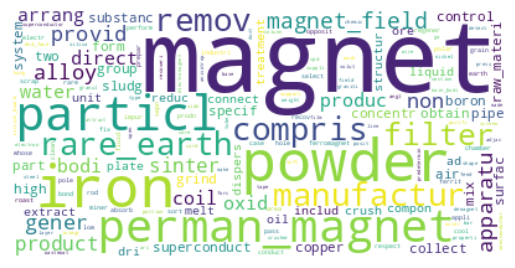

In [ ]:
#Word Cloud- Yopic Modelling

import matplotlib.pyplot as plt

%matplotlib inline

words=[]
for i in range(0,len(ta_ds1)):
  for w in ta_ds1[i]:
    words.append(w)

#words_to_remove=()
words_to_remove=("materi","involv","wast",'batteri','use','method','separ', 'process','recycl','metal','contain','devic','resin','heat','e.g')


from wordcloud import WordCloud

text = " ".join([w for w in words if w not in words_to_remove])

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")

plt.show()

In [ ]:
#Computing Coherence Score

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topic_areas, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

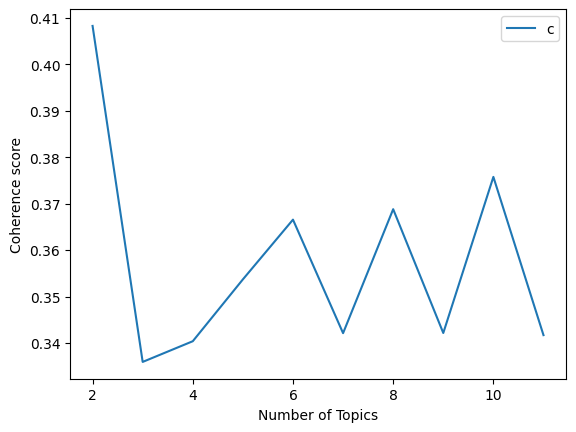

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, tfidf[corpus],final_titles,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph(final_titles,start,stop,step)

In [ ]:
# Conducting PCA and K-Means

# import the necessary libraries
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# create vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# vectorizer the text documents
vectorized_documents = vectorizer.fit_transform(words)

# reduce the dimensionality of the data using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(vectorized_documents.toarray())


# cluster the documents using k-means
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, n_init=5,
                max_iter=500, random_state=42)
kmeans.fit(vectorized_documents)

print('\n clusters and words associated')
words= vectorizer.get_feature_names_out()
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))



 clusters and words associated
0 : involv, process, separ, contain, devic, heat, resin, remov, compris, recoveri, compon, acid, board, liquid, apparatu, electr, plastic, circuit, solut, electron, recov, product, magnet, ga, copper
1 : materi, raw, treatment, zorba, exhibit, exclud, excrement, excreta, execut, exempt, exert, exfoli, exhaust, exist, exchang, exit, exotherm, expand, expans, expect, expel, expens, experi, experiment, excit
2 : oxid, tin, indium, non, anti, solid, photo, sub, lead, exfoli, excrement, excreta, execut, exempt, exert, zorba, exhaust, excit, exhibit, exist, exit, exotherm, expand, expans, expect
3 : metal, non, contain, ion, contg, plastic, typ, mix, synthet, multi, ammonium, contamin, aluminum, tin, air, includ, electrolyt, remov, resin, exhaust, excrement, excreta, execut, exempt, exert
4 : wast, lamp, cell, acid, zorba, exhibit, excrement, excreta, execut, exempt, exert, exfoli, exhaust, exit, exist, excit, exotherm, expand, expans, expect, expel, expens, e

['01' '02' '04' ... 'zones' 'zoom' 'zorba']
(8867, 8869)
n_samples: 8867, n_features: 8869


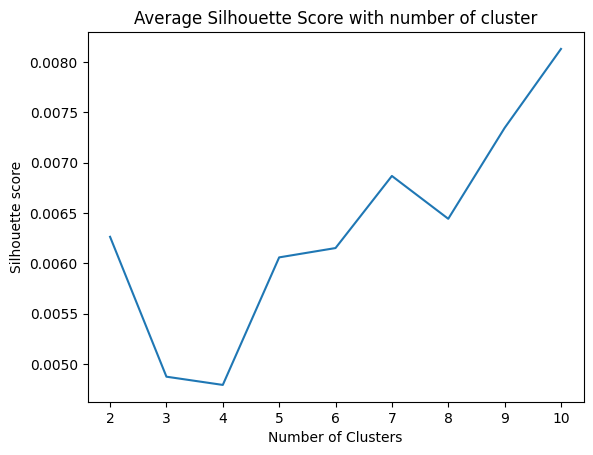

In [ ]:
#Computing Silhouette Score

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(p_ds["DWPI Title"])
words= vectorizer.get_feature_names_out()
print(words)
print(X_tfidf.shape)
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")



ss=[]
for i in range(2,11):
    kmeans=KMeans(n_clusters=i, max_iter=100, n_init=1, random_state=5)
    kmeans.fit(X_tfidf)
    ss1=silhouette_score(X_tfidf,kmeans.fit_predict(X_tfidf))
    ss.append(ss1)

plt.plot(range(2,11),ss)
plt.title('Average Silhouette Score with number of cluster')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.show()

Cluster 0: involv process separ contain devic heat resin remov compris recoveri
Cluster 1: materi raw treatment zorba exhibit exclud excrement excreta execut exempt
Cluster 2: oxid tin indium non anti solid photo sub lead exfoli
Cluster 3: metal non contain ion contg plastic typ mix synthet multi
Cluster 4: wast lamp cell acid zorba exhibit excrement excreta execut exempt
Cluster 5: recycl non treatment zorba exhibit excrement excreta execut exempt exert
Cluster 6: method wet zorba exhaust excit exclud excrement excreta execut exempt
Cluster 7: use zorba exhaust excit exclud excrement excreta execut exempt exert
Cluster 8: sodium sulphur contain sulfhydryl sulfur acid exert exchang excit exclud
Cluster 9: batteri waste air metal zorba exhibit excrement excreta execut exempt


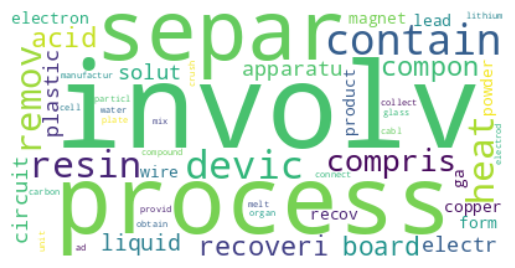

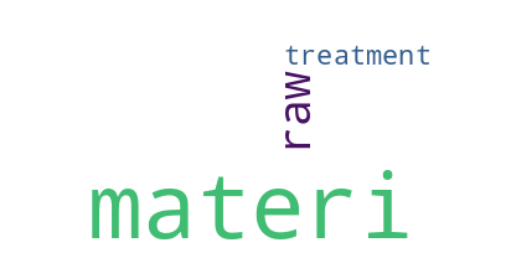

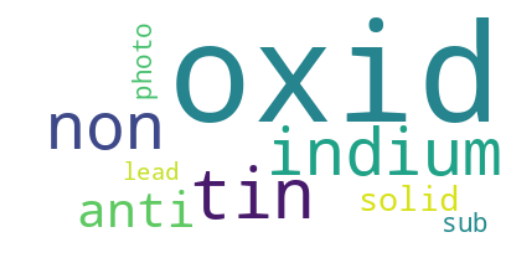

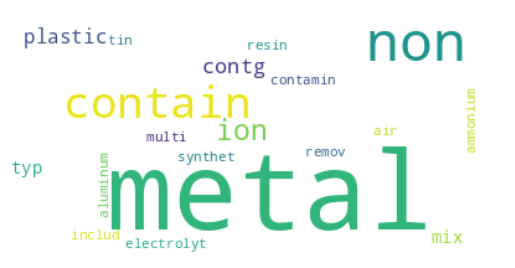

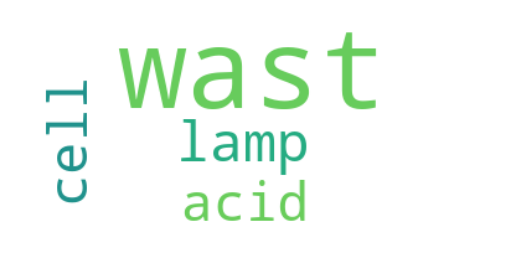

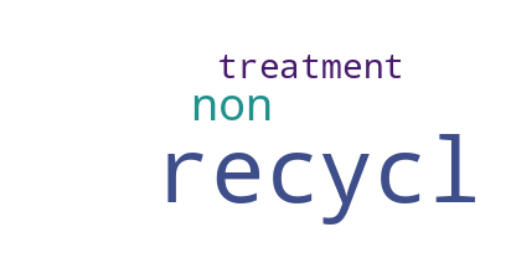

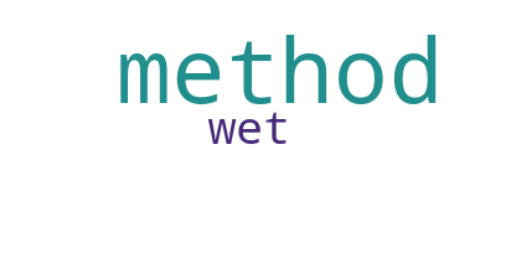

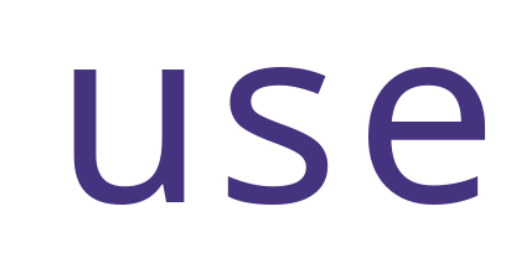

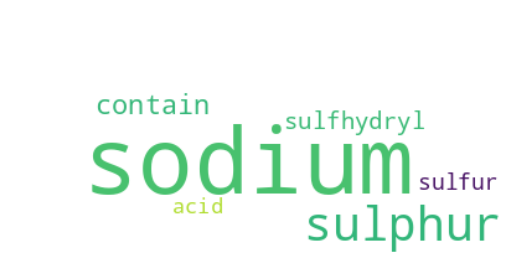

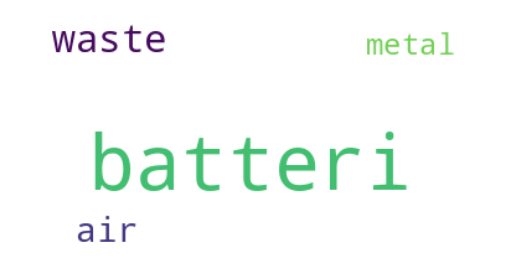

In [ ]:
#Word Clouds Visualisation for K-Means

centroids = kmeans.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names_out()

true_k=10
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

def frequencies_dict(cluster_index):
    if cluster_index > true_k - 1:
        return
    term_frequencies = kmeans.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()